In [6]:
import pickle
from collections import Counter

import pandas as pd
import numpy as np
import pybedtools as pybt
import conorm

import matplotlib.pyplot as plt
import seaborn as sns
from mycolorpy import colorlist as mcp
from matplotlib_venn import venn2,venn3


import os
import sys
sys.path.append("/home/ualtintas/bluegill/")
import bluegill.run as bgrun
import bluegill.plt as bgplt


color1=mcp.gen_color(cmap="Reds",n=10)[-7:-2]
color2=mcp.gen_color(cmap="Greys",n=10)[-5:]

sns.set(style='ticks', font_scale=2)

# Cis-Regulatory Elements (CRE)
CREs are theoretically open chromatin regions which can be captured through ATAC-seq. 
Most well-known classes of CREs are, promoters and enhancers. 

Here we started defining them. 


In [7]:
%%bash

# 1. We generated consecutive BED files for each time point by merging 'narrow' and 'broad' peaks
path=/groups/lackgrp/projects/col-matt-LNCaP/ProcessedDataSeo/ATAC.BED
parallel cat $path/AT{}* \
	'|' "awk '{if (\$9 > 10) print \$0}' " \
	'|' cut -f1-3 '|' sort -k1,1 -k2,2n \
	'|' bedtools merge -i - \
		'>' data/ALL/ATAC.{}.bed  ::: Vh 30m 4h 16h 72h

cat data/ALL/ATAC* \
| cut -f1-3 \
| sort -k1,1 -k2,2n \
| bedtools merge -i - \
| bedtools intersect -a - -b /groups/lackgrp/genomeAnnotations/hg19/hg19-blacklist.v2.bed -v \
| awk '{print $1"\t"int(($2+$3)/2)-2500"\t"int(($2+$3)/2)+2500}' \
| grep -v '-' | grep -v '_' \
>  data/ALL/ATAC.ALL.bed

# Promoters 
The longest transcript (canonical) of transcribing (non-zero transcription) genes' +/- 2.5kb from their start-site (end-site if - stranded) of the transcript body is defined (5kb in length) as the promoter of that gene if the chromatin found accessible in ATAC.


### Collect gencode transcripts

In [8]:
# Here we will parse and collect the ncbiRefSeq transcripts.

!bedtools intersect -a /groups/lackgrp/genomeAnnotations/hg19/gencode.v19.annotation.gtf -b /groups/lackgrp/genomeAnnotations/hg19/hg19-blacklist.v2.bed -wa -v | \
	uniq > /groups/lackgrp/genomeAnnotations/hg19/gencode.v19.annotation.bl.gtf

bed = []
with open("/groups/lackgrp/genomeAnnotations/hg19/gencode.v19.annotation.bl.gtf","r") as f:
    for line in f.readlines():
        # skip comments
        if line[0] == "#":
            continue
        # parse each line and consider only 'transcript' as the type (each trascript has unique line) 
        row = line.strip().split("\t")
        Chr, type_, Start, End, Strand, meta = row[0], row[2], row[3], row[4], row[6], row[8]
        if type_ != "transcript":
            continue

        # parse and match 'gene_name' and 'transcript_id' and generate a bed line
        gene = meta[meta.index("gene_name"):].split("\"")[1]
        trns = meta[meta.index("transcript_id"):].split("\"")[1]
        bed.append((Chr, Start, End, gene, Strand, trns, type_))
        
BEDALL = pd.DataFrame(bed, columns = ["Chr", "Start", "End", "Gene", "Strand", "Transcript", 'Type']).drop_duplicates()
        

In [9]:
# Here the resulting salmon TPM table for all samples (`salmon_TPM.tsv`) is averaged and mapped to BEDALL gene promoters, defined above. Further, the cannonical transcripts (highest expressed promoters are selected here).

T = pd.read_table("/groups/lackgrp/projects/col-matt-LNCaP/rnaseq-pipeline/results_hg19/salmon_TPM.tsv") 
T = T.set_index('Name')
MAPexp = T.mean(1).to_dict()

BEDALL['Expression'] = BEDALL['Transcript'].map(MAPexp)

BEDALL = BEDALL[~BEDALL["Expression"].isna()]

BEDALL = BEDALL.sort_values('Expression').drop_duplicates(["Gene"],keep='last').sort_values(["Chr", "Start"])

BEDALL = BEDALL[BEDALL['Expression'] != 0]

In [10]:
# According to the strand info, assign start (+) or end (-) as the center of the promoter
bedpro = []
for i, row in BEDALL.iterrows():
    if row["Strand"] == "+":
        center = int(row["Start"])
    else:
        center = int(row["End"])
    bedpro.append((row["Chr"], center-2500, center+2500, row["Strand"], row["Gene"], row['Transcript'], row['Expression']))


# Remove minus coordinates.  
BEDPRO = pd.DataFrame(bedpro, columns = ["Chr", "Start", "End", "Strand", "Gene",'Transcript', 'Expression']).drop_duplicates()
BEDPRO = BEDPRO[BEDPRO["Start"] > 0].reset_index(drop=True)

bedpro = pybt.BedTool.from_dataframe(BEDPRO)
cre = pybt.BedTool('data/ALL/ATAC.ALL.bed')

BEDPRO = pybt.BedTool.intersect(bedpro, cre, u=True).to_dataframe(names=["Chr", "Start", "End", "Strand", "Gene",'Transcript', 'Expression'])

BEDPRO['Name'] = BEDPRO['Chr'] +':'+ BEDPRO['Start'].astype(str) +'-'+ BEDPRO['End'].astype(str)


BEDPRO["Quartile"] = "low"
BEDPRO.loc[BEDPRO['Expression'] > np.quantile(BEDPRO['Expression'], 0.25), "Quartile"] = "Mid-low"
BEDPRO.loc[BEDPRO['Expression'] > np.quantile(BEDPRO['Expression'], 0.5), "Quartile"] = "Mid-high"
BEDPRO.loc[BEDPRO['Expression'] > np.quantile(BEDPRO['Expression'], 0.75), "Quartile"] = "High"

# Counts of each quartile
Counter(BEDPRO["Quartile"])

Counter({'Mid-low': 3363, 'low': 3363, 'Mid-high': 3363, 'High': 3363})

### Define ANDR genes (HALLMARK_ANDROGEN_RESPONSE)

In [11]:
# Parse the file.
with open("/groups/lackgrp/genomeAnnotations/hallmarks/HALLMARK_ANDROGEN_RESPONSE.v7.5.1.tsv") as f:
    for line in f.readlines():
        row = line.strip().split("\t")
        if row[0] != "MAPPED_SYMBOLS":
            continue
        else:
            hall = row[1].split(",")
            

# To remain the quartile definition of the ANDR genes, we define another file called BEDANDR. And change their definition in BEDPRO which is the promoters. 
BEDANDR = BEDPRO[BEDPRO["Gene"].isin(hall)]
BEDPRO.loc[BEDPRO["Gene"].isin(hall), 'Quartile'] = 'ANDR'


# Final counts of each quartile after ANDR definition.
Counter(BEDPRO["Quartile"])


Counter({'Mid-low': 3348,
         'low': 3358,
         'Mid-high': 3341,
         'High': 3316,
         'ANDR': 89})

### TMM normalize the expression

In [12]:
T["Vh"] = T[["LNCaP_Vh_1","LNCaP_Vh_2"]].mean(1)
T["30m"] = T[["LNCaP_30m_1","LNCaP_30m_2"]].mean(1)
T["4h"] = T[["LNCaP_4h_1","LNCaP_4h_2"]].mean(1)
T["16h"] = T[["LNCaP_16h_1","LNCaP_16h_2"]].mean(1)
T["72h"] = T[["LNCaP_72h_1","LNCaP_72h_2"]].mean(1)



S = np.nan_to_num(T[['Vh', '30m', '4h', '16h', '72h']])
R = 1 /(conorm.tmm_norm_factors(S) * S.sum(0) / 1000000)
N = pd.DataFrame(S * R, index=T.index, columns=['Vh', '30m', '4h', '16h', '72h'])
N = N.loc[set(BEDPRO['Transcript']).intersection(set(N.index)), :]

for h in ['Vh', '30m', '4h', '16h', '72h']:
    quarts = dict(zip(N.index, N[h]))
    BEDPRO[h] = BEDPRO["Transcript"].map(quarts)

/tmp/ipykernel_121054/1458147444.py:12: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  N = N.loc[set(BEDPRO['Transcript']).intersection(set(N.index)), :]


### Save 

In [13]:
BEDPRO[['Chr', 'Start', 'End']].to_csv('data/BED/PRO.bed', sep='\t', header=False, index=False)
pickle.dump(BEDPRO, open('data/P/BEDPRO.p', 'wb'))

# Enhancers

Enhancers are defined according to the AR-ChIPseq and ATACseq regions. These are open chromatin regions that are not promoters (should not overlap with promoters). 
And next we split them into ARcre and cre according to AR binding.data/ATAC.ALL.bed

In [14]:
%%bash

path=/groups/lackgrp/projects/col-matt-LNCaP/AR-FOXA1
parallel cat $path/DHT_FOX_{}* \
	'|' "awk '{if (\$5 > 10) print \$0}' " \
	'|' cut -f1-3 \
	'|' sort -k1,1 -k2,2n \
	'|' bedtools merge -i - \
		'>' data/ALL/FOXA1.{}.bed  ::: Vh 30m 4h 16h 72h

cat data/ALL/FOXA1* \
| cut -f1-3 \
| sort -k1,1 -k2,2n \
| bedtools merge -i - \
| bedtools intersect -a - -b /groups/lackgrp/genomeAnnotations/hg19/hg19-blacklist.v2.bed -v \
| awk '{print $1"\t"int(($2+$3)/2)-2500"\t"int(($2+$3)/2)+2500}' \
| grep -v '-' | grep -v '_' \
>  data/ALL/FOXA1.ALL.bed

cat $path/DHT_AR_* \
| cut -f1-3 \
| sort -k1,1 -k2,2n \
| bedtools merge -i - \
| bedtools intersect -a - -b /groups/lackgrp/genomeAnnotations/hg19/hg19-blacklist.v2.bed -v \
| awk '{print $1"\t"int(($2+$3)/2)-2500"\t"int(($2+$3)/2)+2500}' \
| grep -v '-' | grep -v '_' \
>  data/ALL/AR.ALL.bed


intervene venn -i data/ALL/ATAC.ALL.bed data/BED/PRO.bed data/ALL/AR.ALL.bed -o data/VENN/ARvsATACvsPRO --save-overlaps
intervene venn -i data/ALL/ATAC.ALL.bed data/ALL/FOXA1.ALL.bed data/ALL/AR.ALL.bed -o data/VENN/ARvsATACvsFOXA1 --save-overlaps



Generating a 3-way "venn" diagram. Please wait...


Done! Please check your results @ data/VENN/ARvsATACvsPRO. 
Thank you for using Intervene!


Generating a 3-way "venn" diagram. Please wait...


Done! Please check your results @ data/VENN/ARvsATACvsFOXA1. 
Thank you for using Intervene!



In [15]:


# cre: is open chromatin regions other than ARBS and PROMOTERS
cre = pd.read_table('data/VENN/ARvsATACvsPRO/sets/100_ATAC.ALL.bed', names=['Chr', 'Start', 'End'])
cre['Name'] = cre['Chr'] +':'+ cre['Start'].astype(str) +'-'+ cre['End'].astype(str)
cre['Set'] = 'cre'

# ARcre: is open chromatin regions that are bound with AR and not PROMOTERS
ARcre = pd.read_table('data/VENN/ARvsATACvsPRO/sets/101_ATAC.ALL_AR.ALL.bed', names=['Chr', 'Start', 'End'])
ARcre['Name'] = ARcre['Chr'] +':'+ ARcre['Start'].astype(str) +'-'+ ARcre['End'].astype(str)
ARcre['Set'] = 'ARcre'

ARcrep = pd.read_table('data/VENN/ARvsATACvsPRO/sets/111_ATAC.ALL_PRO_AR.ALL.bed', names=['Chr', 'Start', 'End'])
ARcrep['Name'] = ARcrep['Chr'] +':'+ ARcrep['Start'].astype(str) +'-'+ ARcrep['End'].astype(str)
ARcrep['Set'] = 'ARcre'

BEDENH = pd.concat((cre,ARcre, ARcrep)).reset_index(drop=True)


### Save

In [16]:
MAPcl = {**dict(zip(BEDENH['Name'], BEDENH['Set'])), **dict(zip(BEDPRO['Name'], BEDPRO['Quartile']))}
pickle.dump(MAPcl, open('data/MAP/MAPcl.p', 'wb'))

MAPty = {**dict(zip(BEDENH['Name'], ['Enhancer']*BEDENH.shape[0])), **dict(zip(BEDPRO['Name'],  ['Promoter']*BEDPRO.shape[0]))}
pickle.dump(MAPty, open('data/MAP/MAPty.p', 'wb'))

MAPgn = dict(zip(BEDPRO['Name'], BEDPRO['Gene']))
pickle.dump(MAPgn, open('data/MAP/MAPgn.p', 'wb'))

In [17]:
BEDCRE = pd.concat((BEDENH[['Chr', 'Start', 'End']], BEDPRO[['Chr', 'Start', 'End']])).sort_values(['Chr', 'Start']).reset_index(drop=True)
BEDCRE['Name'] = BEDCRE['Chr'] +':'+ BEDCRE['Start'].astype(str) +'-'+ BEDCRE['End'].astype(str)
BEDCRE.to_csv('data/BED/CRE.bed', sep='\t', header=False, index=False)

In [18]:
# Optional data!

#BEDENH[['Chr', 'Start', 'End']].to_csv('data/ENH.bed', sep='\t', header=False, index=False)
#pickle.dump(BEDENH, open('data/BEDENH.p', 'wb'))

#BEDCRE = pd.concat((BEDENH[['Chr', 'Start', 'End']], BEDPRO[['Chr', 'Start', 'End']])).sort_values(['Chr', 'Start']).reset_index(drop=True)
#BEDCRE['Name'] = BEDCRE['Chr'] +':'+ BEDCRE['Start'].astype(str) +'-'+ BEDCRE['End'].astype(str)

#BEDCRE['Set'] = BEDCRE['Name'].map(MAPcl)
#BEDCRE[BEDCRE['Set'] == 'ARcre'].to_csv('data/BED/ARcre.bed', sep='\t', header=False, index=False)
#BEDCRE[BEDCRE['Set'] == 'cre'].to_csv('data/BED/cre.bed', sep='\t', header=False, index=False)

# Down regulated

In [19]:
BEDPRO['LFC_16h'] = np.log2((BEDPRO['16h']+1) / (BEDPRO['Vh']+1) )
tmp = BEDPRO.sort_values('LFC_16h')
up = tmp.loc[tmp['LFC_16h'] > 1, 'Name'].tolist()
down = tmp.loc[tmp['LFC_16h'] < -1, 'Name'].tolist()

pickle.dump(down, open('data/P/downgenes.p', 'wb'))

Counter(tmp.loc[tmp['LFC_16h'] > 1, 'Quartile']), Counter(tmp.loc[tmp['LFC_16h'] < -1, 'Quartile'])

(Counter({'Mid-low': 25, 'ANDR': 8, 'High': 4, 'low': 15, 'Mid-high': 6}),
 Counter({'low': 7, 'Mid-high': 9, 'Mid-low': 16, 'High': 4}))

# Signal

In [20]:

BED = pd.read_table('data/BED/CRE.bed', names=['Chr', 'Start', 'End', 'Name'])

# >>> 1 >>>
BWS = []
for signal in ["ATAC","H3K27ac", "H3K4me3", 'AR', 'FOXA1']:
    for h in ["Vh","30m","4h","16h","72h"]:
        BWS += [f"/groups/lackgrp/projects/col-matt-LNCaP/SIGNAL/{signal}_{h}.bw"]
# <<< 1 <<<

#/groups/lackgrp/projects/col-matt-LNCaP/SIGNAL/

In [21]:
Nbins=1
h=1000

BED, samples = bgrun.runSignal(BED, BWS, "data/P/Epigenome.p",  Nbins=Nbins, h=h, nP=100)


S = pickle.load(open("data/P/Epigenome.p","rb"))
N = np.concatenate((
    bgrun.runTMM(S[:,0:5,:])[:,:,0],
    bgrun.runTMM(S[:,5:10,:])[:,:,0],
    bgrun.runTMM(S[:,10:15,:])[:,:,0],
    bgrun.runTMM(S[:,15:20,:])[:,:,0],
    bgrun.runTMM(S[:,20:25,:])[:,:,0]),
    axis=1)
samples = [s.split('/')[-1].split('.')[0] for s in BWS]
N = pd.DataFrame(N, columns=samples, index=BED['Name']).drop_duplicates()
N.to_csv('data/TABLE/Epigenome.tmm.tsv', sep='\t')
N

0: ATAC_Vh.bw :: 1: ATAC_Vh.bw :: 2: ATAC_Vh.bw :: 3: ATAC_Vh.bw :: 4: ATAC_Vh.bw :: 5: ATAC_Vh.bw :: 6: ATAC_Vh.bw :: 7: ATAC_Vh.bw :: 8: ATAC_Vh.bw ::  :: 9: ATAC_Vh.bw10: ATAC_Vh.bw :: 11: ATAC_Vh.bw :: 12: ATAC_Vh.bw :: 13: ATAC_Vh.bw5: ATAC_30m.bw4: ATAC_30m.bw2: ATAC_30m.bw1: ATAC_30m.bw3: ATAC_30m.bw ::  ::  ::  ::  ::  :: 14: ATAC_Vh.bw0: ATAC_30m.bw6: ATAC_30m.bw ::  ::  :: 7: ATAC_30m.bw8: ATAC_30m.bw15: ATAC_Vh.bw ::  ::  :: 10: ATAC_30m.bw16: ATAC_Vh.bw ::  :: 11: ATAC_30m.bw17: ATAC_Vh.bw9: ATAC_30m.bw ::  ::  :: 18: ATAC_Vh.bw12: ATAC_30m.bw ::  :: 19: ATAC_Vh.bw :: 20: ATAC_Vh.bw :: 13: ATAC_30m.bw :: 21: ATAC_Vh.bw :: 14: ATAC_30m.bw22: ATAC_Vh.bw ::  :: 23: ATAC_Vh.bw :: 24: ATAC_Vh.bw :: 25: ATAC_Vh.bw15: ATAC_30m.bw16: ATAC_30m.bw6: ATAC_4h.bw10: ATAC_4h.bw ::  :: 5: ATAC_4h.bw ::  ::  ::  :: 12: ATAC_4h.bw8: ATAC_4h.bw3: ATAC_4h.bw26: ATAC_Vh.bw0: ATAC_4h.bw ::  ::  ::  ::  :: 9: ATAC_4h.bw27: ATAC_Vh.bw7: ATAC_4h.bw11: ATAC_4h.bw4: ATAC_4h.bw2: ATAC_4h.bw1: ATAC_4h

,ATAC_Vh,ATAC_30m,ATAC_4h,ATAC_16h,ATAC_72h,H3K27ac_Vh,H3K27ac_30m,H3K27ac_4h,H3K27ac_16h,H3K27ac_72h,...,AR_Vh,AR_30m,AR_4h,AR_16h,AR_72h,FOXA1_Vh,FOXA1_30m,FOXA1_4h,FOXA1_16h,FOXA1_72h
Name,,,,,,,,,,,,,,,,,,,,,
chr1:751985-756985,3.834383,4.523066,4.695316,6.623085,4.419040,12.769195,14.285685,20.968137,19.817552,14.389780,...,9.606560,9.311411,8.353693,9.963635,6.679334,8.701775,7.425261,8.894937,9.911593,7.485097
chr1:760223-765223,58.005570,59.004207,65.132608,60.752536,56.126082,59.354324,57.325784,48.947977,58.628015,94.640139,...,10.363106,18.287092,16.448436,24.363165,17.501758,24.810059,26.977605,34.188124,37.472829,23.471514
chr1:791444-796444,18.165377,15.838600,14.295136,15.571396,16.443382,15.086202,17.384087,16.291468,19.582789,14.504415,...,6.048811,6.045474,8.243211,9.065101,8.005287,6.442393,6.756190,7.306536,5.752348,3.794659
chr1:802847-807847,11.361002,9.617073,9.906814,8.254100,7.833160,1.328569,2.030962,1.776549,1.580868,1.558943,...,11.626109,10.619552,8.309552,13.440391,7.951588,12.501668,6.830916,9.188438,6.218003,8.339481
chr1:863945-868945,4.179159,4.793863,5.702940,4.949167,3.967160,3.679970,3.486420,4.232616,3.742710,2.857412,...,28.189843,22.272197,16.088759,17.530179,38.023451,9.154568,11.534962,7.091068,11.417952,16.903380
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chrY:28496921-28501921,2.026536,1.976366,1.323698,1.433442,1.142139,1.757231,2.675894,1.972255,3.890002,1.940777,...,2.940513,3.824876,7.233274,1.438316,5.320335,3.309142,1.895207,4.040515,2.030994,4.834205
chrY:28508739-28513739,0.311069,0.760599,1.828670,3.859511,1.439521,0.118764,0.476009,0.068420,0.244100,0.000000,...,1.956107,3.879258,8.088575,8.249017,1.631625,1.645081,2.150684,2.247831,2.399318,5.670010
chrY:28534627-28539627,2.228792,1.461876,2.139336,2.650329,2.559283,0.028515,0.168571,0.442911,0.363720,0.233626,...,1.630134,2.565023,1.814692,2.216214,1.734892,2.859472,3.520114,1.443459,2.965703,5.035693


# Figures

### Androgen-induction of AR-regulated and AR-independent genes

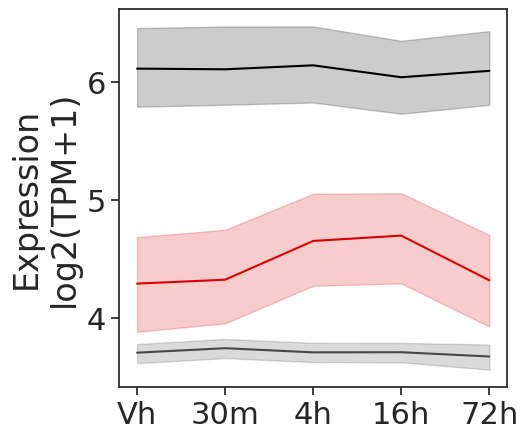

In [22]:
# ANDR genes increase in expression at 4h and 16h.

np.random.seed(7)
tmp = BEDPRO.groupby(['Quartile']).sample(n=89).set_index('Quartile')[['Vh', '30m', '4h','16h', '72h']].stack().reset_index()

tmp['l'] = np.log2(tmp[0]+1)



fig = plt.figure(figsize=[5,5], dpi=100)
ax = sns.lineplot(data=tmp, x='level_1', y='l', hue='Quartile', hue_order=['High', 'ANDR', 'Mid-high'], palette=['#000000', '#DA0000',  color2[-3],]) 

plt.legend([],frameon=False )
plt.ylabel('Expression\nlog2(TPM+1)')
plt.xlabel('')


fig.savefig('plots/ANDRinduction.pdf', bbox_inches ="tight",  pad_inches = 1 )

### Pie chart of ANDR genes in quartiles

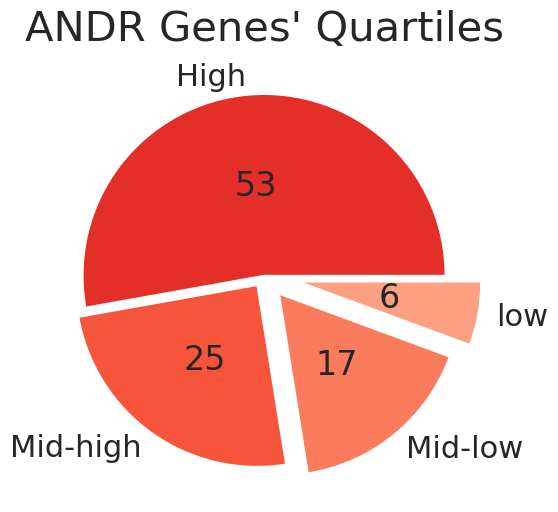

In [23]:
# ANDR genes aligns in High quartlie

data = BEDANDR.groupby('Quartile').size().reset_index().sort_values(0,ascending=False)

fig = plt.figure(figsize=[6,6], dpi=100)
patches, texts, autotexts = plt.pie(
    x=data[0], 
    autopct="%.f", 
    explode=np.linspace(0,0.2, data.shape[0]),
    labels=data["Quartile"], 
    pctdistance=0.5, 
    colors=[  '#e32f27','#f6553c','#fb7c5c', '#fca082'])
plt.title('ANDR Genes\' Quartiles', fontsize=30)

fig.savefig('plots/ANDRQuartilePie.pdf', bbox_inches ="tight",  pad_inches = 1 )

### Bar plot of average expression of quartiles

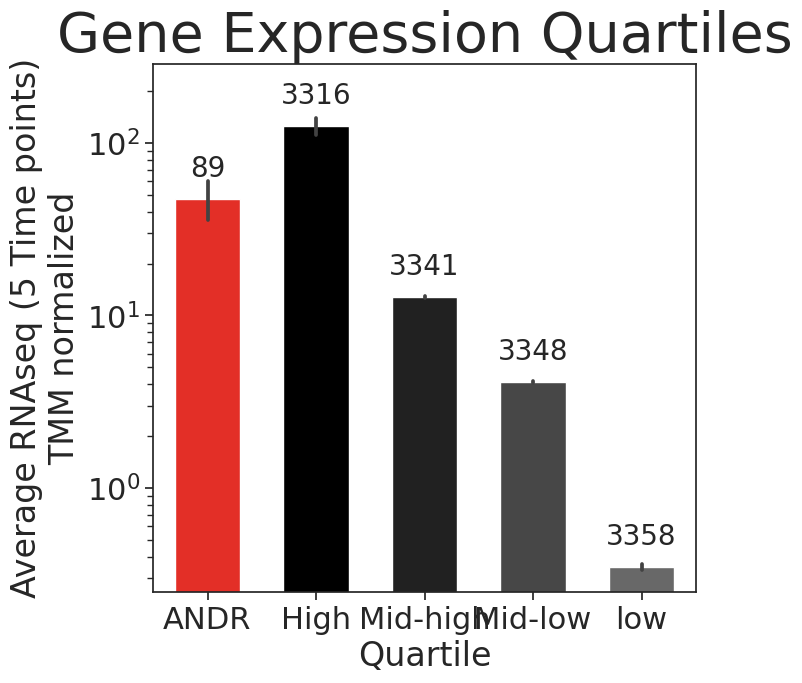

In [24]:
# ANDR genes' expression similar with expression of High quartlie

colorPalette = ['#e32f27'] + color2[::-1]
avg = BEDPRO.groupby('Quartile').mean()['Expression'].to_list()
lab = BEDPRO.groupby('Quartile').size().to_list()

fig = plt.figure(figsize=[7,7], dpi=100)
sns.barplot(data=BEDPRO, x='Quartile', y='Expression', order=['ANDR', 'High', 'Mid-high','Mid-low','low'], palette=colorPalette, saturation=1)

for i, (t,l) in enumerate(zip(avg,lab)):
    plt.text(i, t+t/2, l, fontsize=20,ha='center',va='center')
plt.yscale('log')
plt.title('Gene Expression Quartiles', fontsize=40)
plt.ylabel('Average RNAseq (5 Time points)\nTMM normalized')
y0, y1 = plt.gca().get_ylim()
plt.ylim(y0, y1+100)

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)


ax = plt.gca()
change_width(ax, .6)

fig.savefig('plots/GeneQuartileEXP.pdf', bbox_inches ="tight",  pad_inches = 1 )

### Venn diagram for annotated CREs

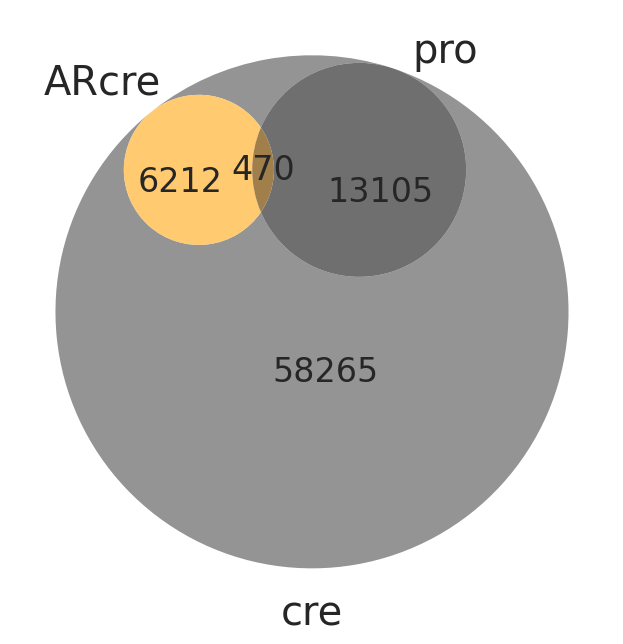

In [25]:

sns.set(style="ticks", font_scale=2)

fig = plt.figure(figsize=[8,8], dpi=100)

with open('data/VENN/ARvsATACvsPRO/sets/111_ATAC.ALL_PRO_AR.ALL.bed') as f:
    n111 = len(f.readlines())

with open('data/VENN/ARvsATACvsPRO/sets/100_ATAC.ALL.bed') as f:
    n100 = len(f.readlines())
            
with open('data/VENN/ARvsATACvsPRO/sets/101_ATAC.ALL_AR.ALL.bed') as f:
    n101 = len(f.readlines())

with open('data/VENN/ARvsATACvsPRO/sets/110_ATAC.ALL_PRO.bed') as f:
    n110 = len(f.readlines())
    
    

venn3((0,0,0,n100,n101,n110,n111), set_labels=('ARcre', 'pro', 'cre'), set_colors=('#f29201', '#000000', '#888888'), alpha=0.9)


fig.savefig('plots/VennCRE_PRO.pdf', bbox_inches ="tight",  pad_inches = 1 )

### Venn diagram for FOXA1 integration

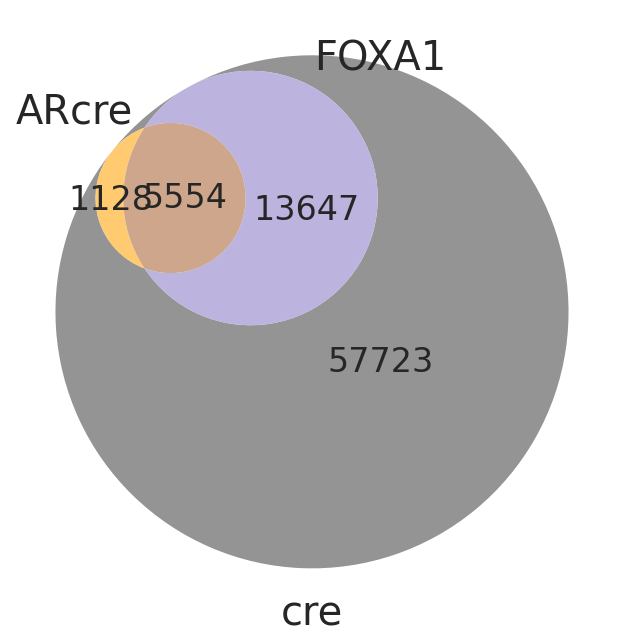

In [26]:

sns.set(style="ticks", font_scale=2)

fig = plt.figure(figsize=[8,8], dpi=100)

with open('data/VENN/ARvsATACvsFOXA1/sets/111_ATAC.ALL_FOXA1.ALL_AR.ALL.bed') as f:
    n111 = len(f.readlines())

with open('data/VENN/ARvsATACvsFOXA1/sets/100_ATAC.ALL.bed') as f:
    n100 = len(f.readlines())
            
with open('data/VENN/ARvsATACvsFOXA1/sets/101_ATAC.ALL_AR.ALL.bed') as f:
    n101 = len(f.readlines())

with open('data/VENN/ARvsATACvsFOXA1/sets/110_ATAC.ALL_FOXA1.ALL.bed') as f:
    n110 = len(f.readlines())
    
    

venn3((0,0,0,n100,n101,n110,n111), set_labels=('ARcre', 'FOXA1', 'cre'), set_colors=('#f29201', '#7A6EB2', '#888888'), alpha=0.9)

fig.savefig('plots/VennCRE_FOXA1.pdf', bbox_inches ="tight",  pad_inches = 1 )

### Down regulated genes induction

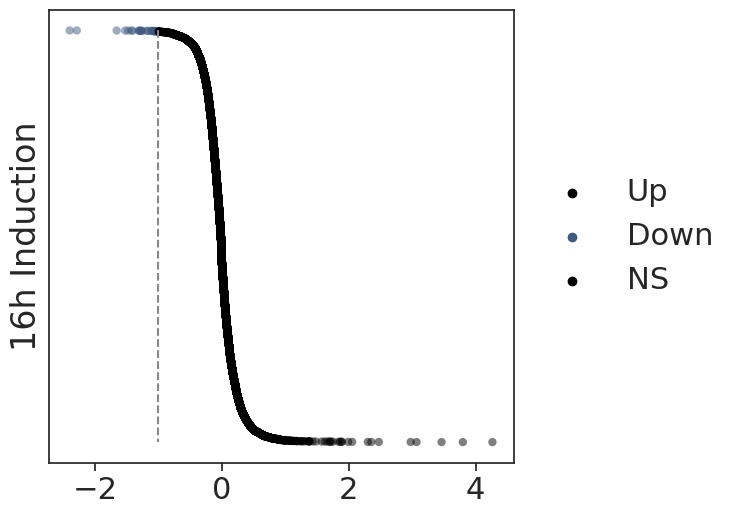

In [28]:
tmp = BEDPRO.sort_values('LFC_16h')

tmp['DE'] = 'NS'
tmp.loc[tmp['LFC_16h'] > 1, 'DE'] = 'Up'
tmp.loc[tmp['LFC_16h'] < -1, 'DE'] = 'Down'

fig = plt.figure(figsize=[6,6], dpi=100)
sns.scatterplot(data=tmp, y='Gene', x='LFC_16h', hue='DE', palette=['#000000', '#3d5a80', '#000000'], hue_order=['Up', 'Down', 'NS'], linewidth=0,alpha=0.5)
plt.yticks([])

plt.plot([-1,-1],[-2,len(tmp)+2], ls='--', c='#888888')

sns.move_legend(plt.gca(), loc='center left', bbox_to_anchor=(1, 0.5), title='', frameon=False)

plt.ylabel('16h Induction')
plt.xlabel('')


fig.savefig('plots/induction_Down.pdf', bbox_inches ="tight",  pad_inches = 1 )


### Down regulated pie

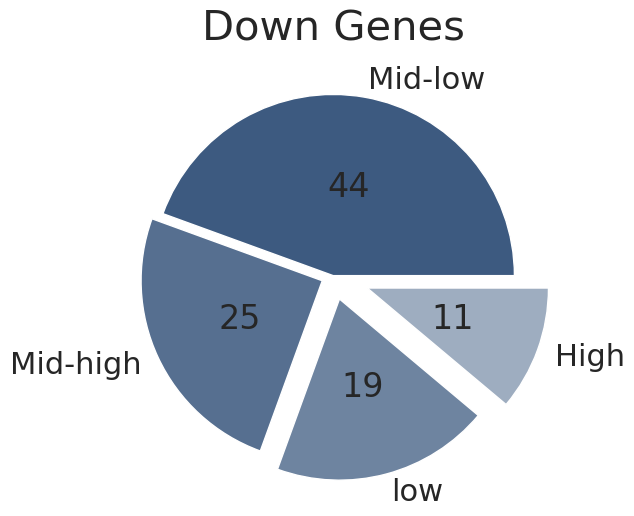

In [29]:
data = tmp[tmp['DE'] == 'Down'].groupby('Quartile').size().reset_index().sort_values(0,ascending=False)

fig = plt.figure(figsize=[6,6], dpi=100)
patches, texts, autotexts = plt.pie(
    x=data[0], 
    autopct="%.f", 
    explode=np.linspace(0,0.2, data.shape[0]),
    labels=data["Quartile"], 
    pctdistance=0.5, 
    colors=[   '#3D5A80', '#566F90', '#6E84A0','#9EADC0'])
plt.title('Down Genes', fontsize=30)


fig.savefig('plots/pie_Down.pdf', bbox_inches ="tight",  pad_inches = 1 )
